# Analysis of Student Data for Union College Math Majors

## Part 6 - Additional data on non-majors

* Received additional data with grades in mathematics courses for all students who took MTH-199 between the 13-14 and 17-18 academic years.
  + This includes the data for majors, analyzed in parts 1-5, and adds data for non-majors who took MTH-199.
<br><br>
* This gives us an opportunity to: 
  + Look at differences between majors and non-majors
  + See if MTH-199 performance is also a good indicator of upper level performance for non-majors 

### Set up the notebook environment

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import union_constants as uc

In [2]:
# Settings
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (6.0, 6.0)
pd.set_option('max_rows', 7)
pd.set_option('max_columns', 50)

In [3]:
# File names
major_data_fn = 'data/union_students_818.xlsx'
major_cleaned_fn = 'data/union_students_818_cleaned.xlsx'
all_grades_fn = 'data/MTH_199_GRADE_HISTORY.xlsx'

### Load and clean the data

* Same formating as previous data (see part 2)
* De-identified ids will not match previous parts, but are internally consistent

In [4]:
# Load grades data
grades = pd.read_excel(all_grades_fn, sheet_name='psa.grdcrshst')

# Column name style preferences
grades.columns = map(str.lower, grades.columns)

# Load student ids from previous data set that contained only math majors
# Use to figure out which IDs are for math majors in new data set
major_info = pd.read_excel(major_data_fn, usecols='A', sheet_name='student info')
major_ids = major_info['@ID'].unique()
grades['major'] = grades['id'].isin(major_ids)

In [5]:
# Compare with previous data set 
# See that assumptions about data for majors being the same holds. Uses actual 
# ids used since the de-identified mapping was not stored. Hidden in final output.
major_grades = pd.read_excel(major_data_fn, sheet_name='psa.grad.grades')
major_grades.columns = map(str.lower, major_grades.columns)
major_grades.drop(['name', 'acad major', 'faculty'], axis=1, inplace=True)

merged_grades = (major_grades
 .merge(grades.loc[grades.major].drop('name', axis=1),
        how='outer', on=['id', 'course', 'term'], suffixes=['_old', '_new'])
 .loc[:, ['id', 'course', 'term', 'grade_old', 'grade_new']])

print('Data for math majors that only appears in one of the data sets:')
merged_grades.loc[merged_grades.grade_old.isnull() | 
                  merged_grades.grade_new.isnull()].drop('id', axis=1)

Data for math majors that only appears in one of the data sets:


,course,term,grade_old,grade_new
778,MTH-219,15/FA,B,NaN
779,MTH-336,16/FA,C,NaN
780,MTH-487,16/FA,B+,NaN
...,...,...,...,...
783,MTH-234,16/WI,B-,NaN
784,MTH-340,16/WI,B+,NaN
785,MTH-340,16/WI,B+,NaN


* The only missing data is for a single math major student who did not take MTH-199

In [6]:
# De-identify ids
#   Reassign student ids to unknown student-id pairings.
#   These will be different from the pairings used in parts 2-5
unique_ids = grades['id'].unique()
np.random.shuffle(unique_ids)
new_ids = {unique_id:idx + 1 for idx, unique_id in enumerate(unique_ids)}
grades['id'] = grades.apply(lambda srs: new_ids[srs['id']], axis=1)

# Drop names
grades.drop(['name'], axis=1, inplace=True)

# Sort
grades.sort_values(['id', 'course'], inplace=True)

In [7]:
# Check for duplicate rows
print('Any duplicate rows? {0}'.format(grades.duplicated().any()))
print()

# Display and drop MTH-000 students
print('Dropped MTH-000:')
display(grades.loc[grades.course == 'MTH-000']) 
grades.drop(grades.loc[grades.course == 'MTH-000'].index, inplace=True)

# Add year column and reassign term to season only
grades['year'] = grades['term'].map(lambda srs: int('20' + srs.split('/')[0]))
grades['term'] = grades['term'].map(lambda srs: srs.split('/')[1])

# Derive grade point columns
grades['point'] = grades['grade'].map(lambda grade: uc.grade_to_point[grade])

Any duplicate rows? False

Dropped MTH-000:


,id,term,course,grade,major
1847,150,16/SU,MTH-000,NC,True
218,247,17/SU,MTH-000,NC,True
2433,334,17/SU,MTH-000,NC,True


### Descriptive statistics

,major,count
1,Yes,109
0,No,263


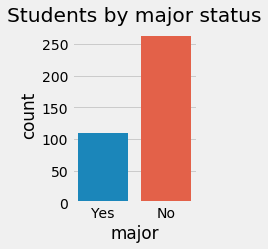

In [8]:
# Count number of majors vs. non-majors
major_count = (grades.groupby('major').apply(lambda df: len(df.id.unique()))
               .to_frame(name='count')
               .rename({True:'Yes', False:'No'})
               .reset_index()
               .sort_values(by='major', ascending=False))

display(major_count)

plt.figure(figsize=(2, 3))
sns.barplot(data=major_count, x='major', y='count', order=['Yes', 'No'])
plt.title('Students by major status')
plt.show()

* Non-majors out numbered majors in MTH-199 roughly 2.5 to 1

,major,count
1,Yes,1221
0,No,1313


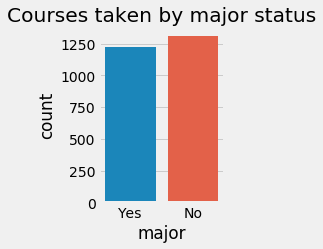

In [9]:
course_count = (grades.groupby('major').id.count()
                .rename({True:'Yes', False:'No'})
                .reset_index()
                .rename(columns={'id':'count'})
                .sort_values(by='major', ascending=False))

display(course_count)

plt.figure(figsize=(2, 3))
sns.barplot(data=course_count, x='major', y='count', order=['Yes', 'No'])
plt.title('Courses taken by major status')
plt.show()

* The total number of math courses taken was nearly the same majors and non-majors
  + That is, majors took about 2.5 times as many math courses overall

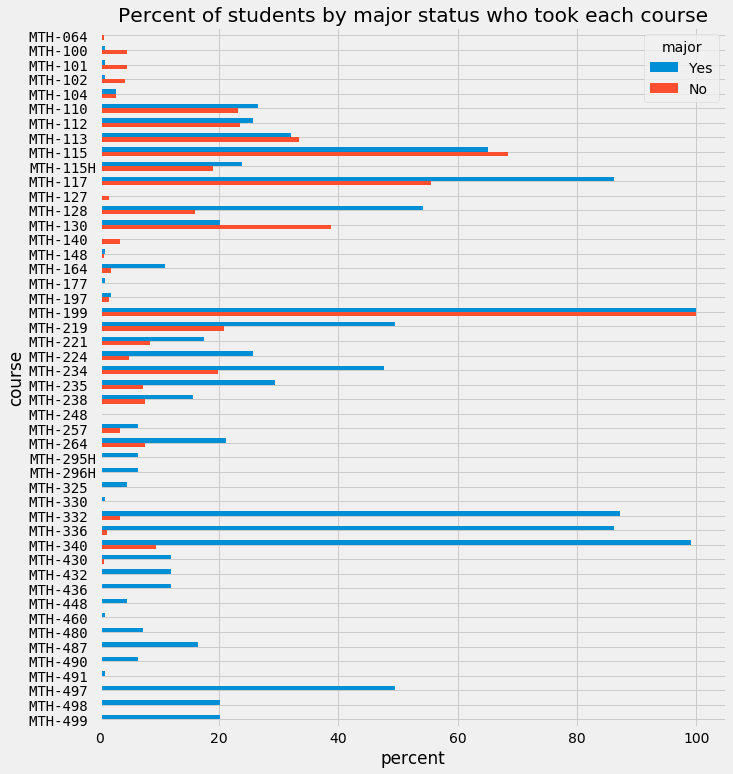

In [10]:
# Courses taken by majors vs. non-majors as a percentage
min_count = 1   # exclude courses taken less than min_count times
graph_data = (grades
 # hack for left aligned tick labels, pad + use monospace font
 .assign(course = lambda srs: srs.course.str.pad(8, 'right'))
 .groupby('course').filter(lambda group: len(group) >= min_count)
 .pivot_table('id', 'major', 'course', aggfunc=len, fill_value=0) 
 .rename({True:'Yes', False:'No'})
 .apply(lambda srs: srs / major_count.loc[major_count.major == srs.name]
                                         ['count'].values[0], axis=1) * 100)

ax = graph_data.T[['Yes', 'No']].plot.barh(figsize=(10, 12), width=0.6)

for tick in ax.get_yticklabels():
    tick.set_fontname('DejaVu Sans Mono')

plt.title('Percent of students by major status who took each course')
plt.gca().invert_yaxis()
plt.xlabel('percent')
plt.show()

* Majors and non-majors took different subsets of courses
  + Math majors take more upper level courses and more courses overall
  + A number of upper level courses are taken exclusively by math majors
  <br><br>
* This affects some interpretation going forward, such as when looking at letter grades for all courses taken

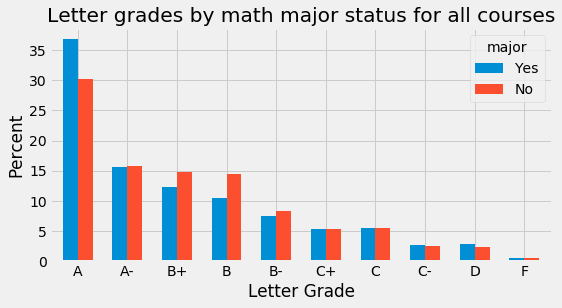

In [11]:
# Letter grade by major vs. non-major as percentage of grades from the 
# corresponding category
(grades
 .drop(grades.loc[grades.grade == 'P'].index)
 .pivot_table('id', 'major', 'grade', aggfunc=len)
 .rename({True:'Yes', False:'No'})
 .sort_index(ascending=False)
 .reindex(columns=uc.grade_rank, fill_value=0.0)
 .apply(lambda srs: srs / sum(srs) * 100, axis=1)).T.plot.bar(figsize=(8, 4),
                                                              width=0.6)
plt.title('Letter grades by math major status for all courses')
plt.xticks(rotation=0)
plt.ylabel('Percent')
plt.xlabel('Letter Grade')
plt.show()

* This distributions are fairly similar between majors and non-majors
  + Majors received A grades somewhat more often while non-majors received more Bs
  + Lower grades (Cs, Ds, Fs) were received nearly equally
<br><br>
* Remember math majors complete more and different upper level math courses. Thus their lower grades may have been received in more difficult courses.

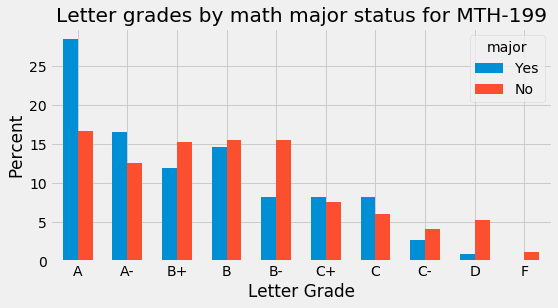

In [12]:
# Letter grades by major vs. non-major as percentage of grades from the 
# corresponding category
(grades
 .drop(grades.loc[(grades.grade == 'P') | (grades.course != 'MTH-199')].index)
 .pivot_table('id', 'major', 'grade', aggfunc=len)
 .rename({True:'Yes', False:'No'})
 .fillna(0)
 .sort_index(ascending=False)
 .reindex(columns=uc.grade_rank, fill_value=0.0)
 .apply(lambda srs: srs / sum(srs) * 100, axis=1)).T.plot.bar(figsize=(8, 4),
                                                              width=0.6)
plt.title('Letter grades by math major status for MTH-199')
plt.xticks(rotation=0)
plt.ylabel('Percent')
plt.xlabel('Letter Grade')
plt.show()

* Here the comparison of majors and non-majors is more straight forward as all students in this data set took MTH-199
* Letter grade trends in MTH-199 are similar to the overall trends with majors earning more A grades and non-majors more Bs.

### Correlations

#### Upper level courses GPA correlation with MTH-199

Looked at correlations between student grades in MTH-199 and GPA in upper level courses (numbered above MTH-199). Same as analysis in part 4, but included non-majors separately.

In [13]:
# Correlation for majors
#   Should be the same as in part 4
mth199_pt = (grades[(grades.course == 'MTH-199') & grades.major]
             .loc[:, ['id', 'point']]
             .set_index('id')
             .rename(columns={'point':'MTH-199'}))

upper_level_avg = (grades[(grades.course > 'MTH-199') & grades.major]
                   .groupby('id').point.agg('mean').to_frame('upper_level_avg'))

points = mth199_pt.join(upper_level_avg)

correlations = (points.corr().loc[['MTH-199'], ['upper_level_avg']]
                      .rename(columns={'upper_level_avg':'correlation'}))

counts = (pd.notnull(points).sum()
          .to_frame('count')
          .drop(['upper_level_avg'], axis='rows'))

correlations = correlations.join(counts)

# Calculate confidence intervals - using Fisher transformation
percent_ci = 95
alpha = 1 - (percent_ci / 100)
z_score = stats.norm.ppf(1 - (alpha / 2))

correlations['ci_low'] = (np.tanh(np.arctanh(correlations['correlation']) - 
                                z_score * 1 / np.sqrt(correlations['count'] - 3)))
correlations['ci_high'] = (np.tanh(np.arctanh(correlations['correlation']) + 
                                z_score * 1 / np.sqrt(correlations['count'] - 3)))

major_correls = correlations.copy().rename({'MTH-199': 'majors'})

In [14]:
# Correlation for non-majors
mth199_pt = (grades[(grades.course == 'MTH-199') & ~grades.major]
             .loc[:, ['id', 'point']]
             .set_index('id')
             .rename(columns={'point':'MTH-199'}))

upper_level_avg = (grades[(grades.course > 'MTH-199') & ~grades.major]
                   .groupby('id').point.agg('mean').to_frame('upper_level_avg'))

points = mth199_pt.join(upper_level_avg)

correlations = (points.corr().loc[['MTH-199'], ['upper_level_avg']]
                      .rename(columns={'upper_level_avg':'correlation'}))

counts = (pd.notnull(points).sum()
          .to_frame('count')
          .drop(['upper_level_avg'], axis='rows'))

correlations = correlations.join(counts)

# Calculate confidence intervals - using Fisher transformation
percent_ci = 95
alpha = 1 - (percent_ci / 100)
z_score = stats.norm.ppf(1 - (alpha / 2))

correlations['ci_low'] = (np.tanh(np.arctanh(correlations['correlation']) - 
                                z_score * 1 / np.sqrt(correlations['count'] - 3)))
correlations['ci_high'] = (np.tanh(np.arctanh(correlations['correlation']) + 
                                z_score * 1 / np.sqrt(correlations['count'] - 3)))

nonmajor_correls = correlations.copy().rename({'MTH-199': 'non-majors'})

In [15]:
correlations = pd.concat([major_correls, nonmajor_correls], axis=0)

print('Correlation of MTH-199 with upper level courses GPA:')
with pd.option_context('display.float_format', '{:,.2f}'.format,
                       'max_rows', None):
    display(correlations.loc[:, ['correlation', 'ci_low', 'ci_high', 'count']])
    

Correlation of MTH-199 with upper level courses GPA:


,correlation,ci_low,ci_high,count
majors,0.74,0.64,0.82,109
non-majors,0.64,0.57,0.71,263


* MTH-199 grade point is slightly less correlated with upper level math course GPA for non-majors than it was for majors.
  + This reduced correlation may be due simply to non-majors taking less upper level courses
  + Though slightly less, it remains a good indicator of upper level performance

#### MTH-199 grade vs mean upper level GPA distributions

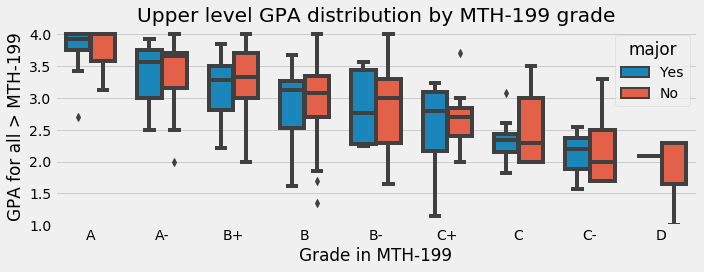

In [16]:
# MTH-199 grade vs mean upper level GPA distributions
upper_level_avg = (grades[grades.course > 'MTH-199']
                   .groupby('id').point.agg('mean').to_frame('upper_level_avg'))

mth199_grade_major = (grades
                      .loc[grades.course == 'MTH-199']
                      .loc[:, ['id', 'grade', 'major']]
                      .set_index('id'))

mth199_grade_major['major'] = (mth199_grade_major['major']
                               .apply(lambda srs: 'Yes' if srs else 'No'))

graph_data = (mth199_grade_major.join(upper_level_avg)
              .sort_values(by='major', ascending=False))

plt.figure(figsize=(10, 4))

sns.boxplot(x='grade', y='upper_level_avg', data=graph_data, hue='major',
            order=uc.grade_rank[:-1],
            width=0.7)
plt.title('Upper level GPA distribution by MTH-199 grade')
plt.xlabel('Grade in MTH-199')
plt.ylabel('GPA for all > MTH-199')
plt.ylim(1, 4.1)
plt.tight_layout()
plt.savefig('images/MTH199_vs_upperlevel_nonmajor.png')
plt.show()

* Looking at using MTH-199 as a predictor of upper level performance
 + Major data is the same as in part 4 figure
<br><br>
* The trend in average grades is similar for majors and non-majors
* The distributions are wider ranging for for non-majors
  + They take fewer upper level math courses and so a single grade has a larger influence on their averages